In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [4]:
symbols = ['PKO.WA', 'MBK.WA']

In [5]:
pkombk = yf.download(symbols, start='2014-01-10', end='2025-11-29')['Close']
print(pkombk.head())

C:\Users\matka\AppData\Local\Temp\ipykernel_26156\2261129459.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pkombk = yf.download(symbols, start='2014-01-10', end='2025-11-29')['Close']
[*********************100%***********************]  2 of 2 completed

Ticker          MBK.WA     PKO.WA
Date                             
2014-01-10  441.432587  27.788746
2014-01-13  450.676056  28.035372
2014-01-14  463.230591  28.760738
2014-01-15  462.632782  29.594900
2014-01-16  462.172913  29.573145


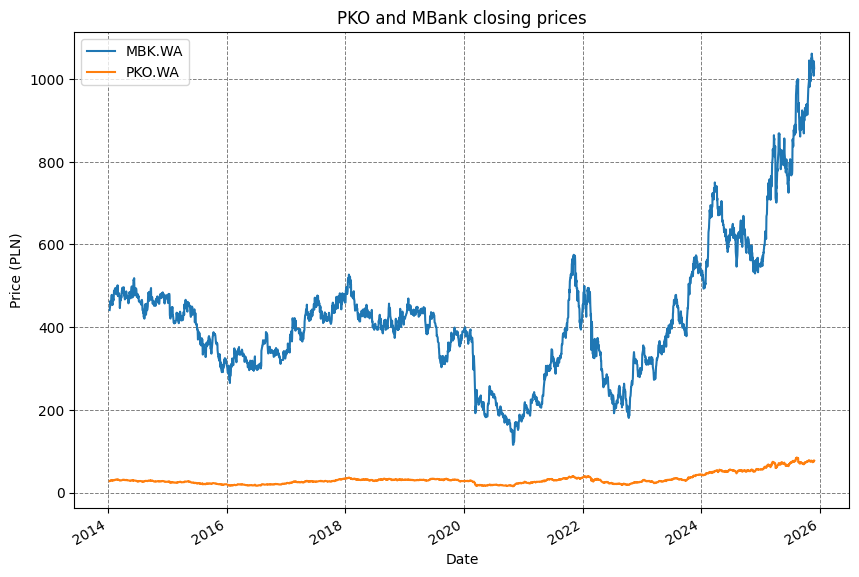

In [6]:
pkombk.plot(figsize=(10,7))
plt.legend()
plt.title('PKO and MBank closing prices')
plt.xlabel('Date')
plt.ylabel('Price (PLN)')
plt.grid(which = 'major', linestyle='--', color='gray', linewidth=0.7)

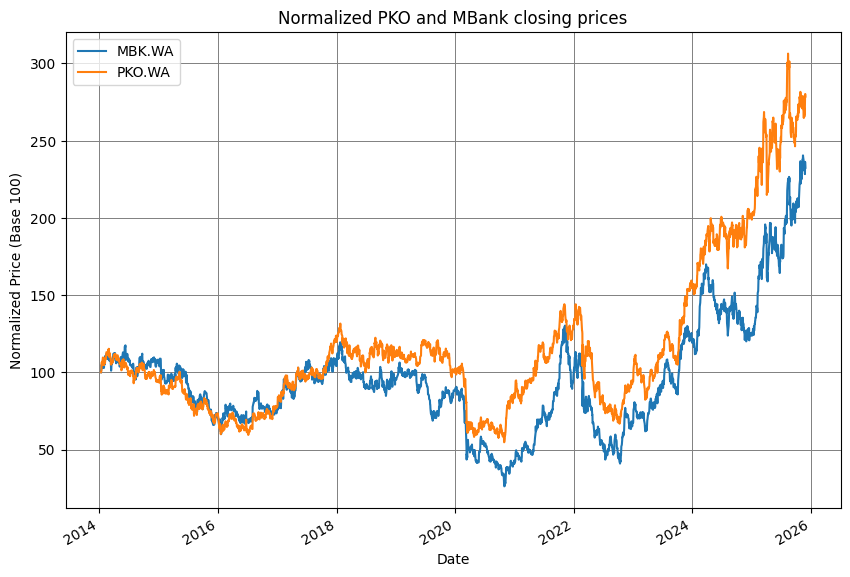

In [7]:
#I see that stocks differ in price too much to directly compare them. I need to normalize them first.
pkombk_normalized = (pkombk/pkombk.iloc[0]) * 100

#Now I can plot normalized prices
pkombk_normalized.plot(figsize=(10,7))
plt.legend()
plt.title('Normalized PKO and MBank closing prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base 100)')
plt.grid(which = 'major', linestyle='-', color='gray', linewidth=0.7)

In [8]:
#As expected, becasue both are large banks operating in the same market
#their stock prices move in a similar way over time.
#This suggests a potential for statistical arbitrage strategies.

price_pko = pkombk['PKO.WA']
price_mbk = pkombk['MBK.WA']

#Calculating logarithmic prices
x = np.log(price_pko)
y = np.log(price_mbk)

#Calculating logarithmic returns
pko_log_returns = x - x.shift(1)
mbk_log_returns = y - y.shift(1)

#combining returns into a single DataFrame and removing NaN values
log_returns = pd.DataFrame({'PKO_Log_Returns': pko_log_returns, 'MBK_Log_Returns': mbk_log_returns})
log_returns = log_returns.dropna()

print(log_returns.head())

            PKO_Log_Returns  MBK_Log_Returns
Date                                        
2014-01-13         0.008836         0.020723
2014-01-14         0.025544         0.027476
2014-01-15         0.028591        -0.001291
2014-01-16        -0.000735        -0.000995
2014-01-17        -0.015075        -0.014836


In [9]:
#Creating correlation matrix
df = log_returns
R = df.values
T, N = R.shape

#Calculating the correlation matrix

# Mean centering the returns
means = np.mean(R, axis=0)
X = R - means

#Covariance matrix
Cov = (X.T @ X) / (T - 1)

#Standard deviations
sigma = np.sqrt(np.diag(Cov))

#Correlation matrix
denominators = np.outer(sigma, sigma)
Corr = Cov / denominators


#Presenting findings
print("1. DAILY VOLATILITY (standard deviation of log returns):")
print(pd.Series(sigma, index=df.columns))

print("\n" + "-" * 50)
print("ANNUALIZED VOLATILITY (Risk per year):")
annualized_vol = sigma * np.sqrt(252)  # Assuming 252 trading days in a year
print(pd.Series(annualized_vol, index=df.columns).apply(lambda x: f"{x:.2%}"))\

print("\n" + "-" * 50)
print("COVARIANCE MATRIX:")
#Scientific notation for better readability
print(pd.DataFrame(Cov, index=df.columns, columns=df.columns))

print("\n" + "-" * 50)
print("CORRELATION MATRIX:")
print(pd.DataFrame(Corr, index=df.columns, columns=df.columns))

1. DAILY VOLATILITY (standard deviation of log returns):
PKO_Log_Returns    0.019932
MBK_Log_Returns    0.024743
dtype: float64

--------------------------------------------------
ANNUALIZED VOLATILITY (Risk per year):
PKO_Log_Returns    31.64%
MBK_Log_Returns    39.28%
dtype: object

--------------------------------------------------
COVARIANCE MATRIX:
                 PKO_Log_Returns  MBK_Log_Returns
PKO_Log_Returns         0.000397         0.000309
MBK_Log_Returns         0.000309         0.000612

--------------------------------------------------
CORRELATION MATRIX:
                 PKO_Log_Returns  MBK_Log_Returns
PKO_Log_Returns         1.000000         0.625849
MBK_Log_Returns         0.625849         1.000000


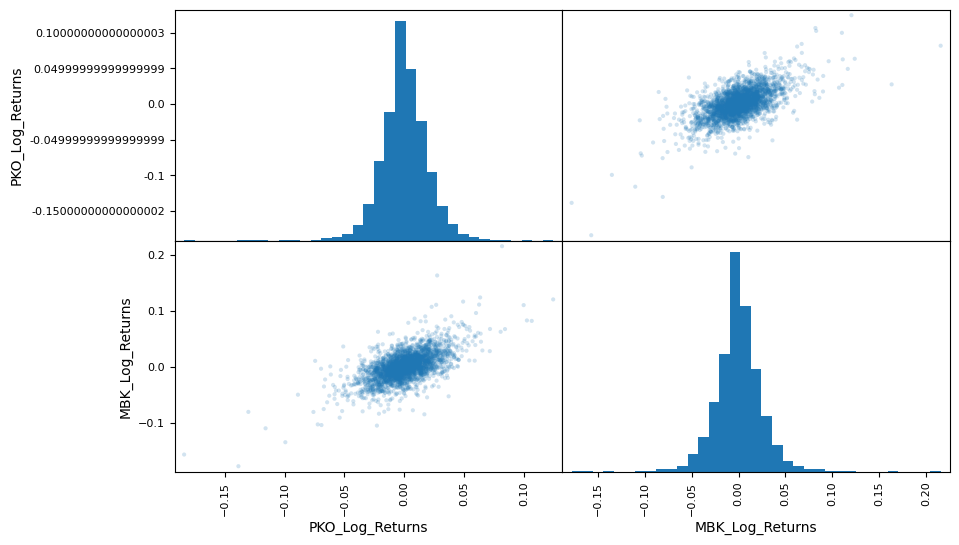

In [ ]:
#Visualizing relationships with pandas scatter matrix

pd.plotting.scatter_matrix(log_returns,
 alpha=0.2,
 diagonal='hist',
 hist_kwds={'bins': 35},
 figsize=(10, 6));




In [19]:
#Having corellaction matrix, I can now move on to cointegeation tests
#I will use Engle-Granger two-step method

#Lets recall logarithmic prices
x = np.log(price_pko)
y = np.log(price_mbk)

#Step 1: Regress y on x to find the hedge ratio
reg = np.polyfit(x, y, 1)
beta = reg[0]
alpha = reg[1]

print(f"Hedge Ratio (Beta): {beta}")

Hedge Ratio (Beta): 0.8681675539653876


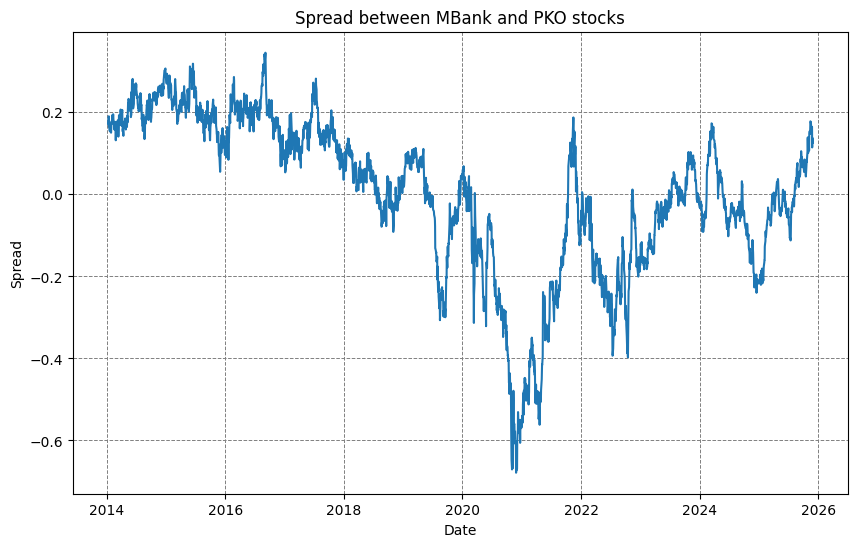

In [20]:
#Calculating and plotting the spread 

spread = y - alpha - beta * x 

plt.figure(figsize=(10,6))
plt.plot(spread)
plt.title('Spread between MBank and PKO stocks')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.grid(which = 'major', linestyle='--', color='gray', linewidth=0.7)